In [ ]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
imgs_path=glob.glob('/content/drive/MyDrive/Colab Notebooks/practice05-birds/birds_train/*/*.jpg')
#imgs_path

## 提取label

In [ ]:
imgs_path[0]

'/content/drive/MyDrive/Colab Notebooks/practice05-birds/birds_train/001.Black_footed_Albatross/0.jpg'

In [ ]:
imgs_path[0].split("/")

['',
 'content',
 'drive',
 'MyDrive',
 'Colab Notebooks',
 'practice05-birds',
 'birds_train',
 '001.Black_footed_Albatross',
 '0.jpg']

In [ ]:
imgs_path[0].split("/")[-2]

'001.Black_footed_Albatross'

In [ ]:
imgs_path[0].split("/")[-2].split(".")[1]

'Black_footed_Albatross'

label提取

In [ ]:
all_labels_name=[imgs_p.split("/")[-2].split(".")[1] for imgs_p in imgs_path]
#查看
len(all_labels_name)

8001

In [ ]:
label_names=np.unique(all_labels_name)
label_names

In [ ]:
label_to_index=dict((name,i) for (i,name) in enumerate(label_names))
label_to_index

label编码

In [ ]:
index_to_label=dict((v,k) for k,v in label_to_index.items())
index_to_label

In [ ]:
all_labels=[label_to_index.get(name) for name in all_labels_name]
len(all_labels)

8001

## 划分数据集

In [ ]:
#将图片随机打乱
random_index=np.random.permutation(len(imgs_path))
random_index

array([3172, 7736, 7467, ..., 6756, 4524, 6972])

In [ ]:
imgs_path=np.array(imgs_path)[random_index]
all_labels=np.array(all_labels)[random_index]

训练集验证集7:3

In [ ]:
i=int(len(imgs_path)*0.7)

In [ ]:
train_path=imgs_path[:i] #训练集路径
train_labels=all_labels[:i] #训练集标签
test_path=imgs_path[i:] #测试集路径
test_labels=all_labels[i:] #测试集标签

In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices((train_path,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_path,test_labels))

In [ ]:
def load_img(path,label):
    img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.resize(img,[256,256])
    img=tf.cast(img,tf.float32)
    img=img/255
    return img,label

In [ ]:
train_ds=train_ds.map(load_img)
test_ds=test_ds.map(load_img)
train_ds

<MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
BATCH_SIZE=32
train_ds=train_ds.repeat().shuffle(300).batch(BATCH_SIZE)

In [ ]:
test_ds=test_ds.batch(BATCH_SIZE)

## 模型

可视化

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def history_plot(history_fit):
    plt.figure(figsize=(12,6))
    
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history_fit.history["accuracy"])
    plt.plot(history_fit.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper left")
    
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history_fit.history["loss"])
    plt.plot(history_fit.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    
    plt.show()

### VGG16

In [ ]:
train_count=len(train_path)
test_count=len(test_path)
steps_per_epoch=train_count//BATCH_SIZE
validation_step=test_count//BATCH_SIZE

fine-tune 模型

In [ ]:
from keras.api._v2.keras import optimizers
from keras.layers import Dense,Dropout,Input,Lambda,BatchNormalization,Conv2D,GlobalAveragePooling2D,multiply,Reshape
from keras.applications import imagenet_utils
from keras.applications.vgg16 import VGG16
from keras import Model

from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

In [ ]:
def fine_tune_model(model, optimizer, batch_size, epochs, freeze_num):

    #仅训练全连接层,冻结所有卷积层
    for layer in model.layers[:freeze_num]:
        layer.trainable = False
    
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    model.fit(train_ds,
         batch_size=batch_size,
         epochs=3,
         shuffle=True,
         verbose=1,
         validation_data=test_ds,
         steps_per_epoch=steps_per_epoch,
         validation_steps=validation_step
        )
    print('Finish step_1')
    
    
    #所有层
    for layer in model.layers[:]:
        layer.trainable = True
    
    rc = ReduceLROnPlateau(monitor="val_accuracy",
                factor=0.2,
                patience=4,
                verbose=1,
                mode='max')

    model_name = model.name  + ".hdf5"
    mc = ModelCheckpoint(model_name, 
               monitor="val_accuracy", 
               save_best_only=True,
               verbose=1,
               mode='max')
    el = EarlyStopping(monitor="val_accuracy",
              min_delta=0,
              patience=5,
              verbose=1,
              restore_best_weights=True)
    
    model.compile(optimizer=optimizer, 
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
           metrics=["accuracy"])

    history_fit = model.fit(train_ds,
                 batch_size=batch_size,
                 epochs=epochs,
                 shuffle=True,
                 verbose=1,
                 validation_data=test_ds,
                 callbacks=[mc,rc,el],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_step
                 )
    
    print('Finish fine-tune')
    return history_fit


VGG16模型

In [ ]:
n_classes=200

In [ ]:
def vgg16_model(img_rows,img_cols):
  x = Input(shape=(img_rows, img_cols, 3))
  x = Lambda(imagenet_utils.preprocess_input)(x)
  base_model = VGG16(input_tensor=x,weights="imagenet",include_top=False, pooling='avg')
  x = base_model.output
  x = Dense(1024,activation="relu",name="fc1")(x)
  x = Dropout(0.5)(x)
  predictions = Dense(n_classes,activation="relu",name="predictions")(x)

  vgg16_model = Model(inputs=base_model.input,outputs=predictions,name="vgg16")
  
  return vgg16_model


创建模型

In [ ]:
img_rows, img_cols = 256,256
vgg16_model = vgg16_model(img_rows,img_cols)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_model.summary()

In [ ]:
optimizer = optimizers.Adam(learning_rate=0.0001)
batch_size = BATCH_SIZE
epochs = 100
freeze_num = 10


%time vgg16_history = fine_tune_model(vgg16_model,optimizer,batch_size,epochs,freeze_num)


Epoch 1/3
175/175 [==============================] - 2373s 13s/step - loss: 5.3027 - accuracy: 0.0063 - val_loss: 5.2985 - val_accuracy: 0.0071
Epoch 2/3
175/175 [==============================] - 82s 470ms/step - loss: 5.2987 - accuracy: 0.0034 - val_loss: 5.2984 - val_accuracy: 0.0029
Epoch 3/3
175/175 [==============================] - 81s 466ms/step - loss: 5.2983 - accuracy: 0.0054 - val_loss: 5.2985 - val_accuracy: 0.0029
Finish step_1
Epoch 1/100
175/175 [==============================] - ETA: 0s - loss: 5.3094 - accuracy: 0.0073
Epoch 1: val_accuracy improved from -inf to 0.00292, saving model to vgg16.hdf5
175/175 [==============================] - 124s 686ms/step - loss: 5.3094 - accuracy: 0.0073 - val_loss: 5.2986 - val_accuracy: 0.0029 - lr: 1.0000e-04
Epoch 2/100
175/175 [==============================] - ETA: 0s - loss: 5.2982 - accuracy: 0.0057
Epoch 2: val_accuracy did not improve from 0.00292
175/175 [==============================] - 118s 673ms/step - loss: 5.2982 - a

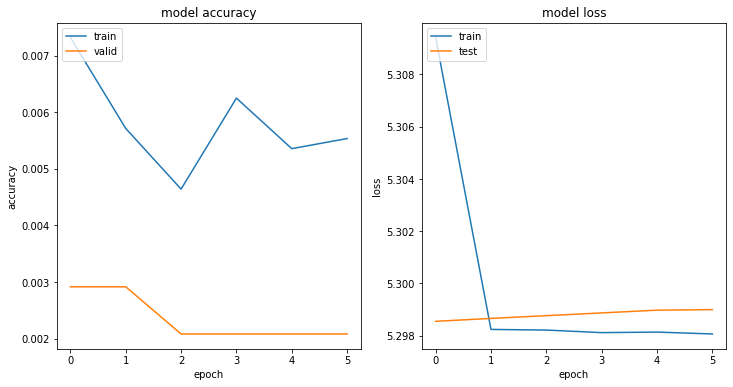

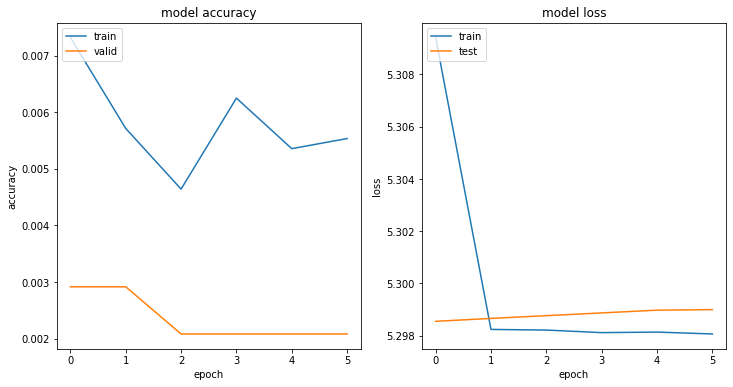

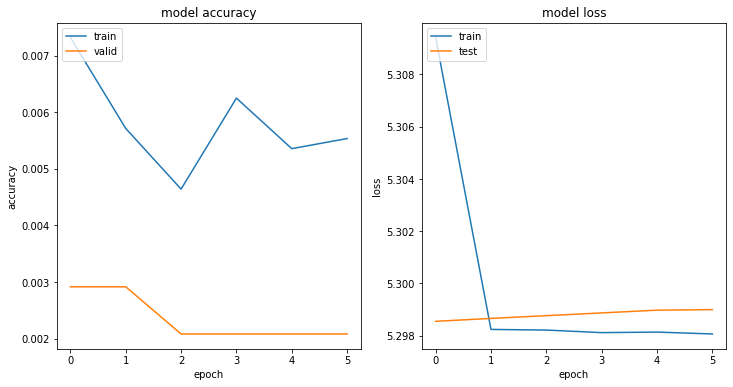

In [ ]:
history_plot(vgg16_history)

### EfficientNet

In [ ]:
from keras.applications.efficientnet import EfficientNetB2
from keras import backend as K

定义一个EfficientNet模型

In [ ]:
def efficient_model(img_rows,img_cols):
  K.clear_session()
  x = Input(shape=(img_rows,img_cols,3))
  x = Lambda(imagenet_utils.preprocess_input)(x)
  
  base_model = EfficientNetB2(input_tensor=x,weights="imagenet",include_top=False,pooling="avg")
  x = base_model.output
  x = Dense(1024,activation="relu",name="fc1")(x)
  x = Dropout(0.5)(x)
  predictions = Dense(n_classes,activation="relu",name="predictions")(x)

  eB_model = Model(inputs=base_model.input,outputs=predictions,name="eB2")

  return eB_model


创建模型

In [ ]:
img_rows, img_cols = 256,256
eB_model = efficient_model(img_rows,img_cols)

In [ ]:
eB_model.summary()

In [ ]:
optimizer = optimizers.Adam(learning_rate=0.0001)
batch_size = BATCH_SIZE
epochs = 50
freeze_num = 469
eB_model_history  = fine_tune_model(eB_model,optimizer,batch_size,epochs,freeze_num)

In [ ]:
history_plot(eB_model.history)

## efficientnet-with-attention

In [ ]:
from keras.applications.efficientnet import EfficientNetB3

attention模块

In [ ]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

def attach_attention_module(net, attention_module):
  if attention_module == 'se_block': # SE_block
    net = se_block(net)
  elif attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

def se_block(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
  #Sequeeze：进行全局池化
	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
  #Excitation ：两层全连接
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)
  #特征重标定：乘法加权
	se_feature = multiply([input_feature, se_feature])
	return se_feature

def cbam_block(cbam_feature, ratio=8):
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature._keras_shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	#平均池化
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	#最大池化
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
  #共享连接层
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	#特征加和
	cbam_feature = Add()([avg_pool,max_pool])
  #sigmoid激活
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature._keras_shape[-1]
		cbam_feature = input_feature
	#平均池化
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	#最大池化
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	#concat
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	#卷积操作
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])


创建efficient-with-attention模型

In [ ]:

def efficient__atten2_model(img_rows,img_cols):
  K.clear_session()
  
  in_lay = Input(shape=(img_rows,img_cols,3))
  base_model = EfficientNetB3(input_shape=(img_rows,img_cols,3),weights="imagenet",include_top=False)
  pt_features = base_model(in_lay)
  bn_features = BatchNormalization()(pt_features)

  atten_features = attach_attention_module(bn_features,"se_block")
  gap_features = GlobalAveragePooling2D()(atten_features)

  gap_dr = Dropout(0.25)(gap_features)
  dr_steps = Dropout(0.25)(Dense(1000,activation="relu")(gap_dr))
  out_layer = Dense(n_classes,activation="softmax")(dr_steps)
  eb_atten_model = Model(inputs=[in_lay],outputs=[out_layer])

  return eb_atten_model


In [ ]:
img_rows,img_cols = 256,256
eB_atten2_model = efficient__atten2_model(img_rows,img_cols)

In [ ]:
for i,layer in enumerate(eB_atten2_model.layers):
  print(i,layer.name)


0 input_1
1 efficientnetb3
2 batch_normalization
3 global_average_pooling2d
4 reshape
5 dense
6 dense_1
7 multiply
8 global_average_pooling2d_1
9 dropout
10 dense_2
11 dropout_1
12 dense_3


In [ ]:
optimizer = optimizers.Adam(learning_rate=0.0001)
batch_size = 32
epochs = 30
freeze_num = 19
eB_atten2_model_history  = fine_tune_model(eB_atten2_model,optimizer,batch_size,epochs,freeze_num)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


175/175 [==============================] - 85s 404ms/step - loss: 5.3065 - accuracy: 0.0052 - val_loss: 5.3040 - val_accuracy: 0.0054
Epoch 2/3
175/175 [==============================] - 59s 334ms/step - loss: 5.3045 - accuracy: 0.0045 - val_loss: 5.3040 - val_accuracy: 0.0054
Epoch 3/3
175/175 [==============================] - 57s 327ms/step - loss: 5.3074 - accuracy: 0.0050 - val_loss: 5.3040 - val_accuracy: 0.0054
Finish step_1
Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 5.1769 - accuracy: 0.0370
Epoch 1: val_accuracy improved from -inf to 0.00708, saving model to model.hdf5
175/175 [==============================] - 181s 939ms/step - loss: 5.1769 - accuracy: 0.0370 - val_loss: 5.3203 - val_accuracy: 0.0071 - lr: 1.0000e-04
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 4.1785 - accuracy: 0.1998
Epoch 2: val_accuracy did not improve from 0.00708
175/175 [==============================] - 159s 912ms/step - loss: 4.1785 - accuracy: 0.1

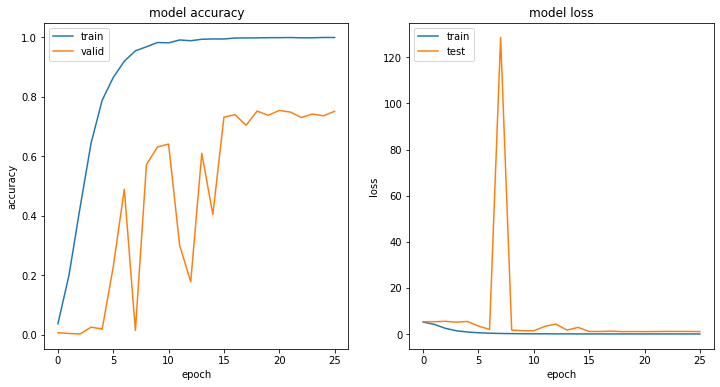

In [ ]:
history_plot(eB_atten2_model_history)

自定义attention

In [ ]:


def efficient_attention_model(img_rows,img_cols):
  K.clear_session()
  
  in_lay = Input(shape=(img_rows,img_cols,3))
  base_model = EfficientNetB3(input_shape=(img_rows,img_cols,3),weights="imagenet",include_top=False)
  pt_features = base_model(in_lay)
  
  pt_depth = base_model.get_output_shape_at(0)[-1]

  
  bn_features = BatchNormalization()(pt_features)
  #attention
  atten_layer = Conv2D(64,kernel_size=(1,1),padding="same",activation="relu")(Dropout(0.5)(bn_features))
  atten_layer = Conv2D(16,kernel_size=(1,1),padding="same",activation="relu")(atten_layer)
  atten_layer = Conv2D(8,kernel_size=(1,1),padding="same",activation="relu")(atten_layer)
  atten_layer = Conv2D(1,kernel_size=(1,1),padding="valid",activation="sigmoid")(atten_layer)# H,W,1

  up_c2_w = np.ones((1,1,1,pt_depth)) #1,1,C
  up_c2 = Conv2D(pt_depth,kernel_size=(1,1),padding="same",activation="linear",use_bias=False,weights=[up_c2_w])
  up_c2.trainable = False
  atten_layer = up_c2(atten_layer)# H,W,C
  #特征标定
  mask_features = multiply([atten_layer,bn_features])# H,W,C

  gap_features = GlobalAveragePooling2D()(mask_features)# 1,1,C

  gap_dr = Dropout(0.25)(gap_features)
  dr_steps = Dropout(0.25)(Dense(1000,activation="relu")(gap_dr))
  out_layer = Dense(200,activation="softmax")(dr_steps)
  eb_atten_model = Model(inputs=[in_lay],outputs=[out_layer])

  return eb_atten_model


In [ ]:
img_rows,img_cols = 256,256
eB_atten_model = efficient_attention_model(img_rows,img_cols)

In [ ]:
for i,layer in enumerate(eB_atten_model.layers):
  print(i,layer.name)


0 input_1
1 efficientnetb3
2 batch_normalization
3 dropout
4 conv2d
5 conv2d_1
6 conv2d_2
7 conv2d_3
8 conv2d_4
9 multiply
10 global_average_pooling2d
11 dropout_1
12 dense
13 dropout_2
14 dense_1


In [ ]:
optimizer = optimizers.Adam(learning_rate=0.0001)
batch_size = 32
epochs = 30
freeze_num = 12
eB_atten_model_history  = fine_tune_model(eB_atten_model,optimizer,batch_size,epochs,freeze_num)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


175/175 [==============================] - 1023s 6s/step - loss: 5.3124 - accuracy: 0.0032 - val_loss: 5.3155 - val_accuracy: 0.0037
Epoch 2/3
175/175 [==============================] - 56s 319ms/step - loss: 5.3077 - accuracy: 0.0037 - val_loss: 5.3191 - val_accuracy: 0.0021
Epoch 3/3
175/175 [==============================] - 56s 322ms/step - loss: 5.3047 - accuracy: 0.0036 - val_loss: 5.3204 - val_accuracy: 0.0033
Finish step_1
Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 4.2269 - accuracy: 0.1554
Epoch 1: val_accuracy improved from -inf to 0.00500, saving model to model.hdf5
175/175 [==============================] - 177s 921ms/step - loss: 4.2269 - accuracy: 0.1554 - val_loss: 5.3110 - val_accuracy: 0.0050 - lr: 1.0000e-04
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 1.9226 - accuracy: 0.5216
Epoch 2: val_accuracy did not improve from 0.00500
175/175 [==============================] - 157s 897ms/step - loss: 1.9226 - accuracy: 0.52

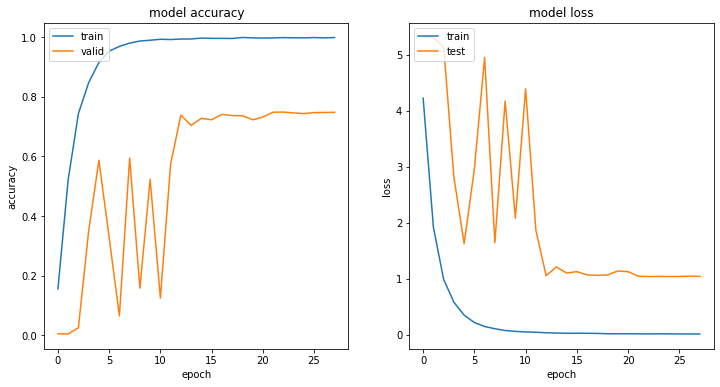

In [ ]:
history_plot(eB_atten_model_history)

## 双线性EfficientNet

定义双线性EfficientNet模型

In [ ]:

def blinear_efficient__atten_model(img_rows,img_cols):
  K.clear_session()
  
  in_lay = Input(shape=(img_rows,img_cols,3))
  base_model = EfficientNetB3(input_shape=(img_rows,img_cols,3),weights="imagenet",include_top=False)
  cnn_features_a = base_model(in_lay)

  pt_depth = base_model.get_output_shape_at(0)[-1]

  
  cnn_bn_features_a = BatchNormalization()(cnn_features_a) 
  
  # attention机制
  #卷积
  atten_layer = Conv2D(64,kernel_size=(1,1),padding="same",activation="relu")(Dropout(0.5)(cnn_bn_features_a))#feature_map
  atten_layer = Conv2D(16,kernel_size=(1,1),padding="same",activation="relu")(atten_layer)
  atten_layer = Conv2D(8,kernel_size=(1,1),padding="same",activation="relu")(atten_layer)
  atten_layer = Conv2D(1,kernel_size=(1,1),padding="valid",activation="sigmoid")(atten_layer)# H,W,1
  up_c2_w = np.ones((1,1,1,pt_depth)) #1,1,C   
  atten_layer = up_c2(atten_layer)# H,W,C
  #乘积
  cnn_atten_out_a = multiply([atten_layer,cnn_bn_features_a])# H,W,C

  cnn_atten_out_b = cnn_atten_out_a
  cnn_out_dot = multiply([cnn_atten_out_a,cnn_atten_out_b])
  #平均池化
  gap_features = GlobalAveragePooling2D()(cnn_out_dot)
  gap_dr = Dropout(0.25)(gap_features)
  dr_steps = Dropout(0.25)(Dense(1000,activation="relu")(gap_dr))
  #输出
  out_layer = Dense(200,activation="softmax")(dr_steps)
  
  b_eff_atten_model = Model(inputs=[in_lay],outputs=[out_layer],name="blinear_efficient_atten")

  return b_eff_atten_model


创建双线性EfficientNet模型

In [ ]:

img_rows,img_cols = 256,256
befficient_model = blinear_efficient__atten_model(img_rows,img_cols)


43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
befficient_model.save("befficient_model.h5")


In [ ]:

optimizer = optimizers.Adam(learning_rate=0.0001)
batch_size = 32
epochs = 30
freeze_num = 19
befficient_model_history  = fine_tune_model(befficient_model,optimizer,batch_size,epochs,freeze_num)


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


175/175 [==============================] - 1004s 5s/step - loss: 5.3063 - accuracy: 0.0039 - val_loss: 5.3019 - val_accuracy: 0.0046
Epoch 2/3
175/175 [==============================] - 58s 331ms/step - loss: 5.3068 - accuracy: 0.0045 - val_loss: 5.3019 - val_accuracy: 0.0046
Epoch 3/3
175/175 [==============================] - 59s 335ms/step - loss: 5.3077 - accuracy: 0.0032 - val_loss: 5.3019 - val_accuracy: 0.0046
Finish step_1
Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 5.2250 - accuracy: 0.0191
Epoch 1: val_accuracy improved from -inf to 0.00250, saving model to blinear_efficient_atten.hdf5
175/175 [==============================] - 182s 943ms/step - loss: 5.2250 - accuracy: 0.0191 - val_loss: 5.3197 - val_accuracy: 0.0025 - lr: 1.0000e-04
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 3.6390 - accuracy: 0.2229
Epoch 2: val_accuracy improved from 0.00250 to 0.00375, saving model to blinear_efficient_atten.hdf5
175/175 [=============

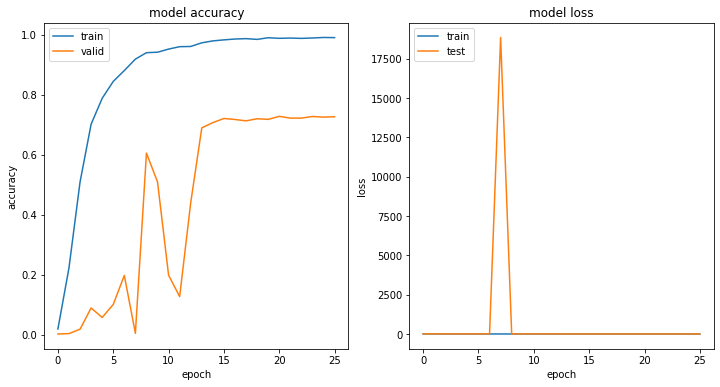

In [ ]:
history_plot(befficient_model_history)